## Sound storage, extraction and internal representation

In [146]:
!pip install dropbox

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import scipy as sc
from scipy.signal import welch
from scipy.fftpack import fft
from scipy.fftpack import dct 
from scipy.fftpack import dst
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import wave
from os.path import *
import os
from functools import partial
import dropbox

#from google.colab import files
import struct
from sklearn.cluster import KMeans

In [2]:
'''
    features.py
    Prototyping feature extraction
    09/04/2018
'''

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import wave
from os.path import *
import os
import dropbox

import struct

def upload_local_file():
    '''used to upload local .wav files f'''
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

class sound:    
    def __init__(self, path, from_drive=True, dbx_access_token='jym07rxV7JAAAAAAAAAASYVjyBOd0G9JJKzC_5dgzrDHKeVsdZG1akcSvWnYBoKd'):
        '''sound object, initialise with path to .wav file'''
        self.from_drive = from_drive
        self.path = path
        self.dbx_access_token = dbx_access_token
        self.dbx = dropbox.Dropbox(self.dbx_access_token)
        self.file = self.read_wave_file()
        self.params, self.raw_audio = self.extract_raw_audio()
        if self.from_drive:
              self.frame_count = self.file.getnframes()
        else:
              self.frame_count = len(self.raw_audio)
    
    def read_wave_file(self):
        if self.from_drive:
            file = wave.open(self.path)
        else:
            if not self.path.startswith('/'):
                path = '/' + self.path
            else:
                path = self.path
            _, file = self.dbx.files_download(path)
            file = file.content
        return file
      
    def parameters(self):
        '''returns parameters of .wav [nchannels, sampwidth, framerate, nframes, comptype, compname]'''
        return self.file.getparams()

    def close(self):
        return self.file.close()
  
    def extract_raw_audio(self): 
        '''extract raw audio needed for dsp'''
        if self.from_drive:
            signal = self.file.readframes(-1)
            raw_audio = np.fromstring(signal,'int16')
            params = self.file.getparams()
        else:
            params, raw_audio = self.read_wav_string(self.file)
        return params, raw_audio
      
    def visualise_time(self):
        '''plot raw_audio'''
        plt.plot(self.raw_audio)
        plt.show()
    
    
    def read_wav_string(self, byte_string):
        wav_file = {'chunk_id': struct.unpack(">I", byte_string[:4]),
                      'chunk_size': struct.unpack("<I", byte_string[4:8]),
                      'format': struct.unpack(">I", byte_string[8:12]),
                      'subchunk1_id': struct.unpack(">I", byte_string[12:16]),
                      'subchunk1_size': struct.unpack(">I", byte_string[16:20]),
                      'audio_format': struct.unpack("<H", byte_string[20:22]),
                      'num_channels': struct.unpack("<H", byte_string[22:24]),
                      'sample_rate': struct.unpack("<I", byte_string[24:28]),
                      'byte_rate': struct.unpack("<I", byte_string[28:32]),
                      'block_align': struct.unpack("<H", byte_string[32:34]),
                      'bits_per_sample': struct.unpack("<H", byte_string[34:36]),
                      'subchunk2_id': struct.unpack(">I", byte_string[36:40]),
                      'subchunk2_size': struct.unpack("<I", byte_string[40:44])}
        data = np.array([struct.unpack("<h", byte_string[44:][i:i+2]) for i in range(len(byte_string[44:]))[::2]])
        wav_file['frame_count'] = len(data)
        wav_file = {k: wav_file[k][0] if isinstance(wav_file[k], tuple) else wav_file for k in wav_file.keys()}
        return wav_file, data
    
def split_audio(audio, nchunks=6):
    N = len(audio)
    samples_per_chunk = N // nchunks
    return [audio[min(i, N - samples_per_chunk): min(N, i + samples_per_chunk)]
            for i in range(0, len(audio), samples_per_chunk)]

def break_down_track(track, nchunks=6):
    return np.array([a for audio in track for a in split_audio(audio, nchunks)])
         

# Feature Extraction

## Low Level Features

### rms value

In [3]:
def rms(raw_audio, analysis_window=441, texture_window=50, overlap=0.5):
    """function to calculate the rms values of subwindows of a signal"""
    # step1: calculate rms values for windows (20ms or so)
    rms_values = [rms_window1(raw_audio[i:i+analysis_window]) for i in range(0,len(raw_audio),round((1-overlap)*analysis_window))]
    # step2: calculate local variance of rms in say 1 second of data i.e 50 windows
    var_values = [rms_variance1(rms_values[i:i+texture_window]) for i in range(0,len(rms_values),texture_window)] 
    # step3: get the mean of these local variances as feature for that sound
    mean = np.mean(var_values)
    return mean #feature
    #return rms_values, var_values, mean #used for visualisation

def rms_window1(window):
    """function return the rms value of a window"""
    window2 = np.array(window, dtype='int64')**2
    return np.sqrt((1/len(window))*np.sum(window2))

def rms_variance1(l_window):
    """function to return local variance over a larger window"""
    return np.var(l_window)  

### percentage low energy frames

In [4]:
def ple(raw_audio, analysis_window=441, texture_window=50, overlap=0.5):
    """function to calculate the percentage low energy frames of a signal"""
    # step1: calculate rms values for windows (20ms or so)
    rms_values = [rms_window2(raw_audio[i:i+analysis_window]) for i in range(0,len(raw_audio),round((1-overlap)*analysis_window))]
    # step2: the average rms value of the last second of data and use 0.5x this as threshold
    mean_values = [past_mean(rms_values[i-texture_window:i]) for i in range(texture_window,len(rms_values))] 
        
    # step3: filter rms according to mean
    rms_adjusted = rms_values[texture_window:]
    ple_frames = [le_filter(rms_adjusted[i], mean_values[i]) for i in range(0,len(mean_values))] 
    nframes = (list(ple_frames).count(1))/float(len(ple_frames))
    return nframes #feature
    #return rms_values, np.insert(mean_values,0,np.zeros(texture_window)), nframes #used for visualisation
    
def rms_window2(window):
    """function return the rms value of a window"""
    window2 = np.array(window, dtype='int64')**2
    return np.sqrt((1/len(window2))*np.sum(window2))
  
def past_mean(mean_window):
    """function to return past mean for an rms value i"""
    return np.mean(mean_window)
  
def le_filter(rms_curr, past_mean):
    """function to filter is low energy frames"""
    return 1 if(rms_curr < past_mean) else 0

### zero crossing rate

In [5]:
def zcr(raw_audio, analysis_window=441, texture_window=50, overlap=0.5):
    """function to compute the zero crossing rate for subwindows of a sound"""    
    # step1: calculate zcr
    zcr_values = [zcr_window(raw_audio[i:i+analysis_window]) for i in range(0,len(raw_audio),round((1-overlap)*analysis_window))]

    # step2: calculate local variance of zcr in say 1 second of data i.e 50 windows
    var_values = [zcr_variance(zcr_values[i:i+texture_window]) for i in range(0,len(zcr_values),texture_window)] 

    # step3: get the mean of these local variances as feature for that sound
    mean = np.mean(var_values)

    return mean #feature
    #return zcr_values, var_values, mean #used for visualisation

def zcr_window(window):
    """calculates the zero crossing rate for a window"""
    length = len(window)
    window1 = window[1:length] # n 
    window2 = window[0:length-1] # (n-1)
    return (1/(length-1))*np.sum(np.absolute(np.sign(window1)-np.sign(window2))) #zcr
     
def zcr_variance(l_window):
    """function to return local variance over a larger window"""
    return np.var(l_window)

### spectral roll-off frequency

In [6]:
def srf(raw_audio, fs=22050, analysis_window=441, texture_window=22050):
    """return var of calculate spectral roll-off frequency"""    
    # obtain power series
    omega = [texture_srf(raw_audio[i:i+texture_window],fs,analysis_window) for i in range(0,len(raw_audio),texture_window)]
    return np.var(omega)
    
def texture_srf(window,fs,analysis_window):
    """return srf for window"""
    # caluclate fraction of bins at which we have 85% of power 
    f, pxx = welch(window, fs=fs, window='hamming', nperseg=analysis_window, noverlap=None)
   
    total_area = np.sum(pxx)
    thresh = 0.85*total_area
    cum = 0.0
    for i in range(0,len(f)):
        if(cum < thresh):
            cum += pxx[i]
        else:
            break
    return f[i]

## MFCC Features

In [7]:
def frame_signal(signal, sampling_rate=44100, frame_size=25, overlap=0.5, center=True):
    """
    Args
        frame_size: (int) frame size in milliseconds
    """
    frame_size = frame_size / 1000. * sampling_rate
    step = int(round(frame_size * (1 - overlap)))
    signal = [signal[i: i + step] for i in range(0, len(signal), step)]    
    if center:
        signal = []
    return signal
    
def mel(f):
    """Map f to mel scale"""
    return 1125 * np.log(1 + f / 700.)

def inverse_mel(m):
    """Map mel frequency to hertz
    Args
        m: (int or numpy array) frequency on mel scale
    Returns
        f (int or numpy array) frequency on hertz scale
    """
    return 700 * (np.exp(m / 1125.) - 1)

def get_mel_filterbank(lower_freq=300, fft_size=257, sampling_rate=22050, num_banks=26):
    mel_lower = mel(lower_freq)
    mel_upper = mel(sampling_rate)
    mel_scale = np.linspace(mel_lower, mel_upper, num_banks + 2)
    
    hertz_scale = inverse_mel(mel_scale)
    hertz_scale = np.floor((fft_size + 1) * hertz_scale / sampling_rate)
    idx = np.arange(fft_size)
    filter_banks = np.zeros((num_banks, fft_size))
    eps = 1e-12
    for m in range(num_banks):
        mask = np.logical_and(idx >= hertz_scale[m], idx <= hertz_scale[m + 1])
        x = (idx - hertz_scale[m]) / (hertz_scale[m + 1] - hertz_scale[m] + eps)
        filter_banks[m, mask] = x[mask]
        mask = np.logical_and(idx >= hertz_scale[m + 1], idx <= hertz_scale[m + 2])
        x = (hertz_scale[m + 2] - idx) / (hertz_scale[m + 2] - hertz_scale[m + 1] + eps)
        filter_banks[m, mask] = x[mask]
    return filter_banks

def get_periodogram(signal, fft_size, frame_size=25, overlap=0.5, center=True):
    frames = frames_signal(audio)
    if center:  # mean-center 
        frames = [frame - sum(frame) / len(frame) for frame in frames]
    ft = np.array(map(partial(np.fft.fft, n=fft_size), frames))
    N = len(frames[0])
    periodogram = np.abs(ft) ** 2 / N
    return periodogram

def mfcc_features(audio, ms_per_frame=20, lower_freq=300, fft_size=512, sampling_rate=22050, num_banks=26, num_keep_mfcc=13):
    frame_size = int(round(ms_per_frame * sampling_rate / 1000.))
    overlap = frame_size // 2
    _, periodogram = welch(audio, fs=sampling_rate, nfft=fft_size, window='hamming', nperseg=frame_size, noverlap=overlap)
    filterbanks = get_mel_filterbank(lower_freq, len(periodogram), sampling_rate, num_banks)
    energies = (periodogram * filterbanks).sum(axis=-1)
    energies = np.log(energies)
    energies = dct(energies)
    features = energies[:num_keep_mfcc]
    return features

# Classification

## File Upload

In [8]:
music = ['bagpipe.wav',
'ballad.wav',
'bartok.wav',
'beatles.wav',
'beat.wav',
'bigband.wav',
'birdland.wav',
'blues.wav',
'bmarsalis.wav',
'brahms.wav',
'canonaki.wav',
'caravan.wav',
'chaka.wav',
'classical1.wav',
'classical2.wav',
'classical.wav',
'copland2.wav',
'copland.wav',
'corea1.wav',
'corea.wav',
'cure.wav',
'debussy.wav',
'deedee1.wav',
'deedee.wav',
'duke.wav',
'echoes.wav',
'eguitar.wav',
'georose.wav',
'gismonti.wav',
'glass1.wav',
'glass.wav',
'gravity2.wav',
'gravity.wav',
'guitar.wav',
'hendrix.wav',
'ipanema.wav',
'jazz1.wav',
'jazz.wav',
'led.wav',
'loreena.wav',
'madradeus.wav',
'magkas.wav',
'march.wav',
'marlene.wav',
'mingus1.wav',
'mingus.wav',
'misirlou.wav',
'moanin.wav',
'narch.wav',
'ncherry.wav',
'nearhou.wav',
'opera1.wav',
'opera.wav',
'pop.wav',
'prodigy.wav',
'redhot.wav',
'rock2.wav',
'rock.wav',
'russo.wav',
'tony.wav',
'u2.wav',
'unpoco.wav',
'vlobos.wav',
'winds.wav']



In [9]:
speech = ['acomic2.wav',
'acomic.wav',
'allison.wav',
'amal.wav',
'austria.wav',
'bathroom1.wav',
'chant.wav',
'charles.wav',
'china.wav',
'comedy1.wav',
'comedy.wav',
'conversion.wav',
'danie1.wav',
'danie.wav',
'dialogue1.wav',
'dialogue2.wav',
'dialogue.wav',
'diamond.wav',
'ellhnika.wav',
'emil.wav',
'female.wav',
'fem_rock.wav',
'fire.wav',
'geography1.wav',
'geography.wav',
'georg.wav',
'god.wav',
'greek1.wav',
'greek.wav',
'india.wav',
'jony.wav',
'jvoice.wav',
'kedar.wav',
'kid.wav',
'lena.wav',
'male.wav',
'my_voice.wav',
'nether.wav',
'news1.wav',
'news2.wav',
'nj105a.wav',
'nj105.wav',
'oneday.wav',
'psychic.wav',
'pulp1.wav',
'pulp2.wav',
'pulp.wav',
'relation.wav',
'serbian.wav',
'shannon.wav',
'sleep.wav',
'smoke1.wav',
'smoking.wav',
'stupid.wav',
'teachers1.wav',
'teachers2.wav',
'teachers.wav',
'thlui.wav',
'undergrad.wav',
'vegetables1.wav',
'vegetables2.wav',
'vegetables.wav',
'voices.wav',
'voice.wav']


In [10]:
sdir = 'data/speech_wav/'
mdir = 'data/music_wav/'

speech = [f for f in speech] 
music  = [f for f in music]
s_audio = [sound(sdir+s).raw_audio for s in speech]
m_audio = [sound(mdir+s).raw_audio for s in music]
s_audio1 = break_down_track(s_audio)
m_audio1 = break_down_track(m_audio)
sm_audio1 = [s+m for s,m in zip(s_audio1,m_audio1)]

# Doesnt work
#s_audio = [s_audio[i:i+(len(a)//2)] for a in s_audio for i in range(0,len(a),(len(a)//2))]
#m_audio = [m_audio[i:i+(len(a)//2)] for a in m_audio for i in range(0,len(a),(len(a)//2))]
#sm_audio = [sm_audio[i:i+(len(a)//2)] for a in sm_audio for i in range(0,len(a),(len(a)//2))]


/home/betz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


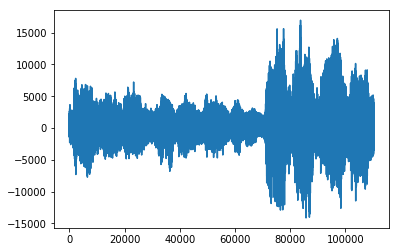

In [398]:
plt.plot(m_audio1[3])

In [305]:
print(s_audio[1])

[ 914 1007  910 ... 2133 1529  916]


In [306]:
#rms = rms(s_audio[1])
ple = ple(s_audio[1])
zcr = zcr(s_audio[1])
srf = srf(s_audio[1])

## Feature Extraction
### Low level feature extraction

In [11]:
"""lowlevel feature vector speech"""
s_rms = [[rms(a)] for a in s_audio1]
s_ple = [[ple(a)] for a in s_audio1]
s_zcr = [[zcr(a)] for a in s_audio1]
s_srf = [[srf(a)] for a in s_audio1]
s_lowlevel = np.concatenate((s_rms,s_ple,s_zcr,s_srf),axis=1)

In [402]:
s_lowlevel[2]

array([9.27910847e+04, 5.57522124e-01, 6.78685950e-04, 2.26400000e+05])

In [12]:
"""lowlevel feature vector music"""
m_rms = [[rms(a)] for a in m_audio1]
m_ple = [[ple(a)] for a in m_audio1]
m_zcr = [[zcr(a)] for a in m_audio1]
m_srf = [[srf(a)] for a in m_audio1]
m_lowlevel = np.concatenate((m_rms,m_ple,m_zcr,m_srf),axis=1)


In [401]:
m_lowlevel[2]

array([1.28630882e+05, 6.30530973e-01, 2.49454990e-03, 1.06600000e+05])

In [13]:
"""lowlevel feature vector speech_music"""
sm_rms = [[rms(a)] for a in sm_audio1]
sm_ple = [[ple(a)] for a in sm_audio1]
sm_zcr = [[zcr(a)] for a in sm_audio1]
sm_srf = [[srf(a)] for a in sm_audio1]
sm_lowlevel = np.concatenate((sm_rms,sm_ple,sm_zcr,sm_srf),axis=1)

In [261]:
s_lowlevel[10]

array([6.49368309e+05, 6.26106195e-01, 2.07340213e-02, 1.04000000e+05])

### MCFF feature extraction

In [14]:
s_mfcc = np.array([mfcc_features(a) for a in s_audio1]) # speech
m_mfcc = np.array([mfcc_features(a) for a in m_audio1]) # audio 
sm_mfcc = np.array([mfcc_features(a) for a in sm_audio1]) # speech and audio

### Combining Low Level and MFCC *features*

In [15]:
s_combined  = np.concatenate((s_lowlevel,s_mfcc),axis=1)
m_combined  = np.concatenate((m_lowlevel,m_mfcc),axis=1)

In [ ]:
sm_combined = np.concatenate((sm_lowlevel,sm_mfcc),axis=1)

## K-Means
### Relevant Imports

In [16]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale

import sklearn.metrics as m
from sklearn import datasets
from sklearn.metrics import confusion_matrix,classification_report

from mpl_toolkits.mplot3d import Axes3D

In [17]:
%matplotlib inline

### low level feature clustering

In [18]:
#X_ll = np.vstack((s_lowlevel,m_lowlevel,sm_lowlevel))
#y_ll = np.array([0]*len(s_lowlevel) + [1]*len(m_lowlevel) + [2]*len(sm_lowlevel))
X_ll = np.vstack((s_lowlevel,m_lowlevel))
y_ll = np.array([0]*len(s_lowlevel) + [1]*len(m_lowlevel))


In [409]:
X_ll

array([[1.30293337e+05, 6.76991150e-01, 2.80467423e-02, 1.44160000e+06],
       [9.92654621e+04, 5.44247788e-01, 1.46328199e-03, 5.69000000e+05],
       [9.27910847e+04, 5.57522124e-01, 6.78685950e-04, 2.26400000e+05],
       ...,
       [1.98401901e+05, 6.28318584e-01, 6.70075655e-04, 1.49400000e+05],
       [2.35173977e+04, 4.73451327e-01, 4.28425076e-04, 1.06000000e+04],
       [2.87975298e+04, 4.44690265e-01, 5.15374686e-04, 4.86000000e+04]])

In [410]:
km_ll = KMeans(n_clusters=2)
labels_ll = km_ll.fit_predict(X_ll)

In [411]:
y_ll

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [412]:
labels_ll

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [413]:
km_ll

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### visualising low level clustering

In [414]:
df = pd.DataFrame(X_ll)
y = pd.DataFrame(y_ll)
df.columns = ['rms','ple','zcr','srf']
y.columns = ['Target']

Text(0.5,1,'K-Means sound classification')

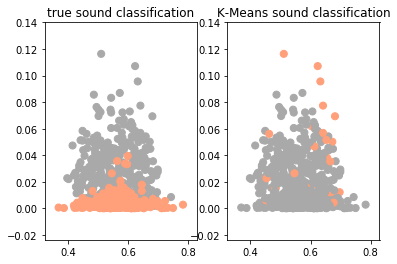

In [415]:
color_theme = np.array(['darkgray','lightsalmon','powderblue'])

plt.subplot(1,2,1)
plt.scatter(x=df.ple,y=df.zcr, c=color_theme[y_ll], s=50)
plt.title("true sound classification")

plt.subplot(1,2,2)
plt.scatter(x=df.ple,y=df.zcr, c=color_theme[labels_ll], s=50)
plt.title("K-Means sound classification")

In [421]:
relable = np.choose(km_ll.labels_,[1,0]).astype(np.int64)
print (classification_report(y_ll,relable))

             precision    recall  f1-score   support

          0       0.76      0.07      0.13       384
          1       0.51      0.98      0.67       384

avg / total       0.63      0.52      0.40       768



#### 3d visualising

Text(0.5,0,'srf')

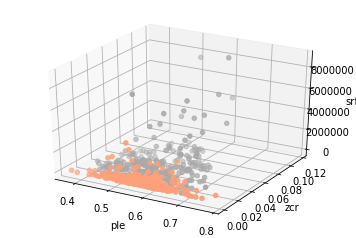

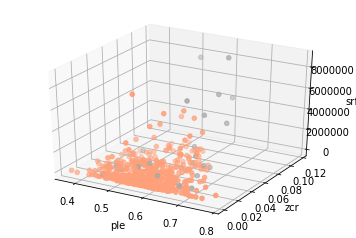

In [447]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.ple,df.zcr,df.srf, c=color_theme[y_ll])
ax.set_xlabel('ple')
ax.set_ylabel('zcr')
ax.set_zlabel('srf')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(df.ple,df.zcr,df.srf, c=color_theme[relable])
ax2.set_xlabel('ple')
ax2.set_ylabel('zcr')
ax2.set_zlabel('srf')

### mfcc feature clustering

In [19]:
X_mfcc = np.vstack((s_mfcc,m_mfcc))
y_mfcc = np.array([0]*len(s_mfcc) + [1]*len(m_mfcc))

In [20]:
km_mfcc = KMeans(n_clusters=2)
labels_mfcc = km_mfcc.fit_predict(X_mfcc)

In [21]:
y_mfcc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
labels_mfcc

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

#### visualising mfcc clustering

In [57]:
df = pd.DataFrame(X_mcff)
y = pd.DataFrame(y_mfcc)
df.columns = ['rms','ple','zcr','srf']
y.columns = ['Target']

NameError: name 'X_mcff' is not defined

Text(0.5,1,'K-Means sound classification')

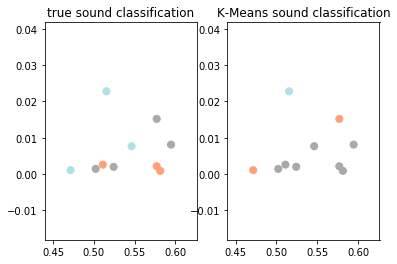

In [58]:
color_theme = np.array(['darkgray','lightsalmon','powderblue'])

plt.subplot(1,2,1)
plt.scatter(x=df.ple,y=df.zcr, c=color_theme[y_ll], s=50)
plt.title("true sound classification")

plt.subplot(1,2,2)
plt.scatter(x=df.ple,y=df.zcr, c=color_theme[labels_ll], s=50)
plt.title("K-Means sound classification")

In [36]:
relable = np.choose(km_mfcc.labels_,[1,0,2]).astype(np.int64)
print (classification_report(y_mfcc,relable))

NameError: name 'km_mfcc' is not defined

### combined feature clustering

In [23]:
X_combined = np.vstack((s_combined,m_combined))
y_combined = np.array([0]*len(s_combined) + [1]*len(m_combined))

In [61]:
km_combined = KMeans(n_clusters=3)
labels_combined = km_mfcc.fit_predict(X_combined)

In [62]:
y_combined

array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2])

In [63]:
labels_combined

array([1, 1, 1, 2, 1, 1, 1, 2, 1, 0], dtype=int32)

In [25]:
import numpy as np
import scipy
import dropbox
%matplotlib inline
from functools import partial
from scipy.fftpack import dct
from scipy.signal import welch
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import v_measure_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

## Supervised Model

In [26]:
def eval_model(X, y, model_fn=SVC, test_size=0.33, standard_scale=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    if standard_scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    model = model_fn()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    return model

## lowlevel

In [27]:
pipeline = make_pipeline(StandardScaler(), SVC())
cv_results = cross_validate(pipeline, X_ll, y_ll, cv=3,
                            scoring=('accuracy', 'precision', 'recall'))

for key in [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]:
    print("Average %s: %.3f" % (key, cv_results[key].mean()))
    print("Standard deviation of %s: %.3f\n" % (key, cv_results[key].std()))

#     print "Test scores:\n", cv_results['test_score']
#     print "Average test accuracy: %.3f" % cv_results['test_score'].mean()
#     print "Standard deviation of test accuracy: %.3f" % cv_results['test_score'].std()

Average test_accuracy: 0.814
Standard deviation of test_accuracy: 0.058

Average train_accuracy: 0.863
Standard deviation of train_accuracy: 0.011

Average test_precision: 0.776
Standard deviation of test_precision: 0.083

Average train_precision: 0.826
Standard deviation of train_precision: 0.013

Average test_recall: 0.906
Standard deviation of test_recall: 0.028

Average train_recall: 0.919
Standard deviation of train_recall: 0.010



/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## MFCC

In [28]:
pipeline = make_pipeline(StandardScaler(), SVC())
cv_results = cross_validate(pipeline, X_mfcc, y_mfcc, cv=3,
                            scoring=('accuracy', 'precision', 'recall'))

for key in [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]:
    print("Average %s: %.3f" % (key, cv_results[key].mean()))
    print("Standard deviation of %s: %.3f\n" % (key, cv_results[key].std()))

#     print "Test scores:\n", cv_results['test_score']
#     print "Average test accuracy: %.3f" % cv_results['test_score'].mean()
#     print "Standard deviation of test accuracy: %.3f" % cv_results['test_score'].std()

Average test_accuracy: 0.803
Standard deviation of test_accuracy: 0.029

Average train_accuracy: 0.956
Standard deviation of train_accuracy: 0.002

Average test_precision: 0.828
Standard deviation of test_precision: 0.046

Average train_precision: 0.961
Standard deviation of train_precision: 0.000

Average test_recall: 0.771
Standard deviation of test_recall: 0.045

Average train_recall: 0.952
Standard deviation of train_recall: 0.005



/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


## Combined

In [29]:
pipeline = make_pipeline(StandardScaler(), SVC())
cv_results = cross_validate(pipeline, X_combined, y_combined, cv=3,
                            scoring=('accuracy', 'precision', 'recall'))

for key in [key for key in cv_results.keys() if key.startswith('test') or key.startswith('train')]:
    print("Average %s: %.3f" % (key, cv_results[key].mean()))
    print("Standard deviation of %s: %.3f\n" % (key, cv_results[key].std()))

#     print "Test scores:\n", cv_results['test_score']
#     print "Average test accuracy: %.3f" % cv_results['test_score'].mean()
#     print "Standard deviation of test accuracy: %.3f" % cv_results['test_score'].std()

Average test_accuracy: 0.908
Standard deviation of test_accuracy: 0.021

Average train_accuracy: 0.990
Standard deviation of train_accuracy: 0.003

Average test_precision: 0.893
Standard deviation of test_precision: 0.031

Average train_precision: 0.983
Standard deviation of train_precision: 0.005

Average test_recall: 0.927
Standard deviation of test_recall: 0.022

Average train_recall: 0.996
Standard deviation of train_recall: 0.003



/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/betz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
